In [22]:
import torch
torch.set_printoptions(sci_mode=False)

In [2]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [7]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)

tensor([0., 1., 2., 3.], requires_grad=True)

In [11]:
x.grad == None

True

In [13]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [14]:
y.backward()

In [15]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [16]:
4 * x

tensor([ 0.,  4.,  8., 12.], grad_fn=<MulBackward0>)

In [17]:
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [18]:
x.grad == 4 * x

tensor([True, True, True, True])

In [19]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [20]:
x.grad

tensor([0., 0., 0., 0.])

In [21]:
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [23]:
x = torch.arange(4, dtype=torch.float32)
x

tensor([0., 1., 2., 3.])

In [25]:
x.requires_grad_(True)

tensor([0., 1., 2., 3.], requires_grad=True)

In [26]:
L = (x**2).sum()
L.backward()

print("L:", L.item())
print("x.grad:", x.grad)

L: 14.0
x.grad: tensor([0., 2., 4., 6.])


In [28]:
y = x**2
y

tensor([0., 1., 4., 9.], grad_fn=<PowBackward0>)

In [31]:
v = torch.ones_like(y)
y.backward(gradient=v)


print("y:", y)
print("x.grad:", x.grad)

y: tensor([0., 1., 4., 9.], grad_fn=<PowBackward0>)
x.grad: tensor([ 0.,  4.,  8., 12.])


In [34]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [36]:
x = torch.tensor([0., 1., 2., 3.], requires_grad=True)
y = x**2

v = torch.tensor([1., 10., 100., 1000.])  # weights
y.backward(gradient=v)

print("v:", v)
print("x.grad:", x.grad)


v: tensor([   1.,   10.,  100., 1000.])
x.grad: tensor([   0.,   20.,  400., 6000.])


In [37]:
x = torch.tensor([0.5, 1.0, 2.0], requires_grad=True)
y = torch.stack([torch.sin(x[0]), torch.exp(x[1]), x[2]**3])  # shape [3]

v = torch.tensor([1., 1., 1.])
y.backward(gradient=v)

print("y:", y)
print("x.grad:", x.grad)


y: tensor([0.4794, 2.7183, 8.0000], grad_fn=<StackBackward0>)
x.grad: tensor([ 0.8776,  2.7183, 12.0000])


In [38]:
A = torch.tensor([[1., 2.],
                  [3., 4.]])
x = torch.tensor([5., 6.], requires_grad=True)

y = A @ x   # shape [2]

v = torch.tensor([1., 1.])          # upstream gradient
y.backward(gradient=v)

print("y:", y)
print("x.grad:", x.grad)


y: tensor([17., 39.], grad_fn=<MvBackward0>)
x.grad: tensor([4., 6.])


In [39]:
import torch
from torch.autograd.functional import jacobian

def f(x):
    return torch.stack([x[0]*x[1], x[0] + x[1]**2])   # y in R^2

x = torch.tensor([2., 3.], requires_grad=True)
J = jacobian(f, x)   # shape (2, 2): dy_i / dx_j

print(J)


tensor([[3., 2.],
        [1., 6.]])


In [40]:
a = torch.randn(size=(), requires_grad=True)
a

tensor(0.4498, requires_grad=True)

In [49]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [50]:
a = torch.tensor([200.0], requires_grad=True)
d = f(a)
d

tensor([1600.], grad_fn=<MulBackward0>)

In [51]:
d.backward()
a.grad

tensor([8.])

In [52]:

def f_with_debug(a):
    b = a * 2
    m = 0
    while b.norm() < 1000:
        b = b * 2
        m += 1

    if b.sum() > 0:
        d = b
        scale = 1.0
        branch = "d = b"
    else:
        d = 100 * b
        scale = 100.0
        branch = "d = 100*b"

    # Since b = a * 2^(m+1), d = scale * a * 2^(m+1) = k * a
    k = scale * (2 ** (m + 1))
    return d, m, branch, k

test_vals = [1.0, -1.0, 0.1, -0.1, 500.0, -500.0]

for val in test_vals:
    a = torch.tensor(val, requires_grad=True)
    d, m, branch, k = f_with_debug(a)

    d.backward()  # d is scalar

    ratio = (d / a).item()  # should equal k (and a.grad) as long as a != 0
    grad = a.grad.item()

    print(f"a={val:>7} | m={m:>2} | {branch:8} | "
          f"k={k:>10.1f} | d/a={ratio:>10.1f} | a.grad={grad:>10.1f}")


a=    1.0 | m= 9 | d = b    | k=    1024.0 | d/a=    1024.0 | a.grad=    1024.0
a=   -1.0 | m= 9 | d = 100*b | k=  102400.0 | d/a=  102400.0 | a.grad=  102400.0
a=    0.1 | m=13 | d = b    | k=   16384.0 | d/a=   16384.0 | a.grad=   16384.0
a=   -0.1 | m=13 | d = 100*b | k= 1638400.0 | d/a= 1638400.0 | a.grad= 1638400.0
a=  500.0 | m= 0 | d = b    | k=       2.0 | d/a=       2.0 | a.grad=       2.0
a= -500.0 | m= 0 | d = 100*b | k=     200.0 | d/a=     200.0 | a.grad=     200.0


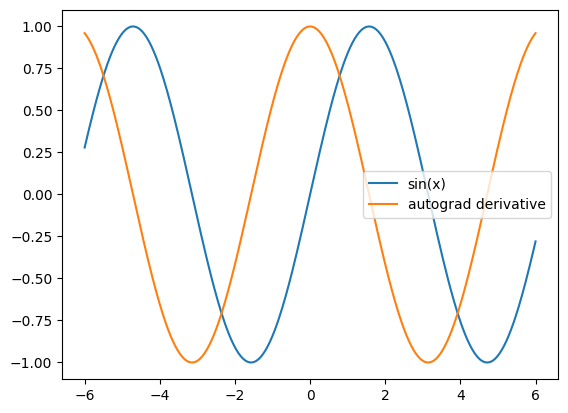

In [53]:
import matplotlib.pyplot as plt

x = torch.linspace(-6, 6, 400, requires_grad=True)
y = torch.sin(x)

# make scalar by summing, so we can backprop
(dy_dx,) = torch.autograd.grad(y.sum(), x)

plt.plot(x.detach(), y.detach(), label="sin(x)")
plt.plot(x.detach(), dy_dx.detach(), label="autograd derivative")
plt.legend()
plt.show()
